# **Auto Regressive with eXogenous input Model**

In [9]:
# Essential packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Statsmodels packages
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_ccf
import statsmodels.api as sm

# Scikit-learn packages
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, ARDRegression, Lasso, ElasticNet
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Warning Supression
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Load data
u_train = np.load("./data/u_train.npy")
y_train = np.load("./data/output_train.npy")

## **Check Data Format**

In [31]:
df = pd.DataFrame(U_train, columns=['U'])
df['Y'] = y_train

pd.set_option('display.max_rows', None)
print(df)

        U          Y
0     5.0  -0.020471
1     5.0   0.047894
2     5.0  -0.051944
3     5.0  -0.055573
4     5.0   0.196578
5     5.0   0.139341
6     5.0   1.009291
7     5.0   2.523175
8     5.0   4.002842
9     5.0   4.945335
10    5.0   5.145747
11    5.0   4.709099
12    5.0   4.667778
13    5.0   4.843826
14    5.0   5.620932
15    5.0   6.532870
16    5.0   7.149765
17    5.0   7.872616
18    5.0   8.209024
19    5.0   7.855255
20    5.0   7.703188
21    5.0   7.897871
22    5.0   8.569772
23    5.0   8.720693
24    5.0   9.309497
25    5.0   9.707275
26    5.0   9.785150
27    5.0   9.695310
28    5.0   9.532500
29    5.0   9.704415
30    5.0   9.726365
31    5.0  10.058139
32    5.0  10.227756
33    5.0  10.467396
34    5.0  10.589341
35    5.0  10.646552
36    5.0  10.380903
37    5.0  10.530203
38    5.0  10.542583
39    5.0  10.886368
40    5.0  10.809513
41    5.0  11.134094
42    5.0  11.004609
43    5.0  11.000182
44    5.0  10.906752
45    5.0  11.065624
46    5.0  11

## **Construction of the regression matrix X and output vector Y**

In [10]:
def BuildArxMatrix(y_train, u_train, n, m, d):
    """
    Constructs the regression matrix X and output vector Y for an ARX model.
    """
    # Calculate the starting index based on the number of lags and delay
    p = max(n, d + m)

    X = []
    Y = []

    for k in range(p, len(y_train)):
        # Create the regressor vector for the current time step `k`
        regressor_vector = []

        # Include past `n` outputs y(k-1), y(k-2), ..., y(k-n)
        for i in range(1, n + 1):
            regressor_vector.append(y_train[k - i])

        # Include past `m+1` inputs u(k-d), u(k-d-1), ..., u(k-d-m)
        for j in range(0, m + 1):
            regressor_vector.append(u_train[k - d - j])

        # Append the regressor vector to X
        X.append(regressor_vector)

        # Append the current output y(k) to Y
        Y.append(y_train[k])

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

#X, _ = BuildArxMatrix(y_train, u_train, 0, 2, 0)
#print(X)

In [ ]:
def Standardize(vector):
  mu = np.mean(vector, axis=0)
  sigma = np.std(vector, axis=0)
  standardized_vector = (vector - mu) / sigma

  return standardized_vector, mu, sigma

## **Selection of optimal values for `m`, `n` and `d`**

In [87]:
def CorrelationPlots(y_train, u_train):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot ACF
    plot_acf(y_train, lags=10, ax=axes[0])
    axes[0].set_title("Autocorrelation Function (ACF) of the output")
    axes[0].set_xlim([-0.5, 10.5])
    axes[0].set_ylim([-1, 1.2])

    # Plot PACF
    plot_pacf(y_train, lags=10, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation Function (PACF) of the output")
    axes[1].set_xlim([-0.5, 10.5])
    axes[1].set_ylim([-1, 1.2])

    # Plot PACF
    plot_ccf(x=u_train, y=y_train, lags=range(6,17), ax=axes[2])
    axes[2].set_title("Cross Correlation Function (CCF) of the output with input")
    axes[2].set_xlim([5.5, 16.5])
    axes[2].set_ylim([-0.25, 0.25])

    plt.tight_layout()
    plt.show()


def two_stage_grid_search(y, u, n_values, m_values, d_values, alpha_values, n_splits=5):
    best_params = None
    best_sse = None
    best_score = float('inf') 
    best_model = None
    best_arx_matrix = None

    # Custom scorer for RMSE
    rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

    # Outer loop: iterate through all combinations of n, m, and d
    for n in n_values:
        for m in m_values:
            for d in d_values:
                print(f"Evaluating for n={n}, m={m}, d={d}")
                
                X_arx, y_arx = BuildArxMatrix(y, u, n, m, d)

                X_arx = X_arx[:int(0.8*2025), :]
                y_arx = y_arx[:int(0.8*2025)]

                mu = np.mean(X_arx, axis=0)
                sigma = np.std(X_arx, axis=0)
                X_arx = (X_arx - mu) / sigma

                tscv = TimeSeriesSplit(n_splits=5)

                model = Ridge(max_iter=5000)
                param_grid = {'alpha': alpha_values}

                grid_search = GridSearchCV(
                    estimator=model,
                    param_grid=param_grid,
                    scoring=['neg_mean_squared_error', 'r2'],
                    cv=tscv,
                    refit='neg_mean_squared_error',
                    verbose=0
                )

                # Fit GridSearchCV to the current ARX matrix
                grid_search.fit(X_arx, y_arx)

                # Retrieve the best model, parameters, and score from GridSearchCV
                best_inner_params = grid_search.best_params_
                best_inner_score = grid_search.best_score_

                print(f"Best alpha for n={n}, m={m}, d={d}: {best_inner_params['alpha']} with inner score RMSE {abs(best_inner_score):.4f}")

                # Step 5: Update the best model if the current one has a lower RMSE
                if abs(best_inner_score) < best_score:
                    best_score = abs(best_inner_score)
                    best_matrix = {'n': n, 'm': m, 'd': d, 'alpha': best_inner_params['alpha']}
                    best_model = grid_search.best_estimator_
                    best_params = grid_search.best_params_
                    best_index = grid_search.best_index_

    # Print best hyperparameter(s) found
    print(f"Best Hyperparameters: {best_params}\n")

    # Print the metrics with respective std dev across folds
    mean_rmse = np.sqrt(-grid_search.cv_results_['mean_test_neg_mean_squared_error'][best_index])
    std_rmse = np.sqrt(grid_search.cv_results_['std_test_neg_mean_squared_error'][best_index])
    mean_r2 = grid_search.cv_results_['mean_test_r2'][best_index]
    std_r2 = grid_search.cv_results_['std_test_r2'][best_index]

    print(f"-> Best Model's Performance")
    print(f"Cross-Validated RMSE: {mean_rmse}")
    print(f"RMSE STD Deviation: {std_rmse}")
    print(f"Cross-Validated R^2: {mean_r2}")
    print(f"R^2 STD Deviation: {std_r2}\n")

    # Return the best model
    return best_model, best_matrix, mu, sigma

# Define ranges for n, m, and d
n_range = [7] # range(8, 10)  
m_range = [8] # range(8, 10) 
d_range = [8] # range(5, 10)  
alpha_values = np.logspace(-10, 0, 100) 

# Call the two-stage grid search
best_model, best_matrix, mu, sigma = two_stage_grid_search(
    y_train, u_train, n_range, m_range, d_range, alpha_values
)

# Coefficients of the best model
n = best_matrix['n']
m = best_matrix['m']
d = best_matrix['d']

coeff_labels = [f"y(k-{i})" for i in range(1, n+1)]  
coeff_labels += [f"u(k-{d}-{j})" for j in range(m+1)]  

print("Coefficients of the best model:")
for label, coeff in zip(coeff_labels, best_model.coef_):
    print(f"{label}: {coeff:.4f}")


Evaluating for n=7, m=8, d=8
Best alpha for n=7, m=8, d=8: 0.01519911082952933 with inner score RMSE 0.2482
Best Hyperparameters: {'alpha': 0.01519911082952933}

-> Best Model's Performance
Cross-Validated RMSE: 0.4981880289793176
RMSE STD Deviation: 0.16339481858838537
Cross-Validated R^2: 0.9933866040814913
R^2 STD Deviation: 0.002468821871851504

Coefficients of the best model:
y(k-1): 14.8248
y(k-2): -5.7940
y(k-3): -3.0769
y(k-4): 0.5246
y(k-5): 3.2127
y(k-6): 1.2457
y(k-7): -3.4559
u(k-8-0): -0.8014
u(k-8-1): -0.4237
u(k-8-2): 0.0586
u(k-8-3): 0.1307
u(k-8-4): -0.1859
u(k-8-5): 0.0179
u(k-8-6): 0.0576
u(k-8-7): 0.0381
u(k-8-8): -0.2387


SSE: 129.21864031176153



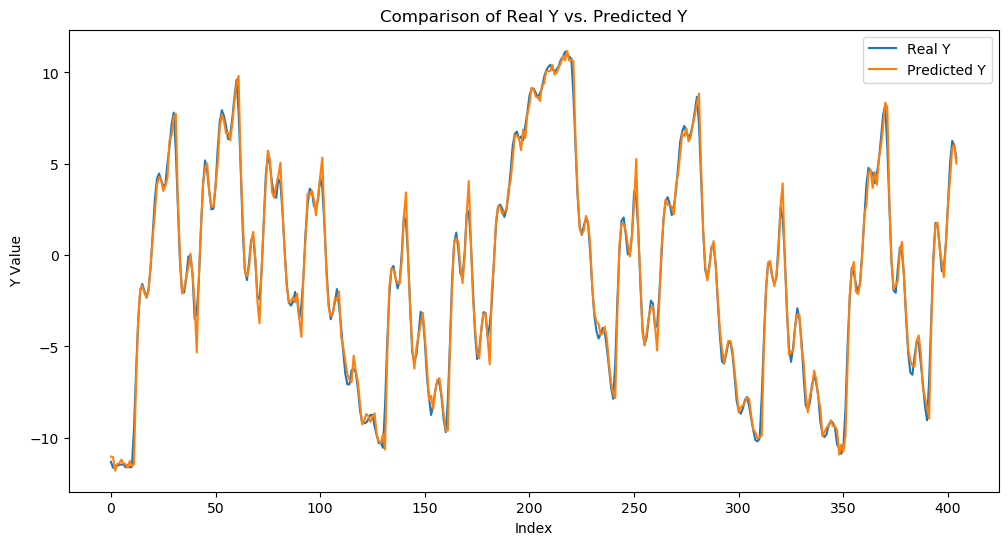

In [88]:
X_best_arx, y_best_arx = BuildArxMatrix(y_train, u_train, n, m, d)
X_best_arx_norm = (X_best_arx[int(0.8*len(X_best_arx)):, :] - mu) / sigma

y_pred = best_model.predict(X_best_arx_norm)
print(f"SSE: {np.sum((y_pred - y_best_arx[int(0.8*len(X_best_arx)):])**2)}\n")

plt.figure(figsize=(12, 6))
plt.plot(y_best_arx[int(0.8*len(X_best_arx)):], label="Real Y", linestyle='-')
plt.plot(y_pred, label="Predicted Y", linestyle='-')
plt.xlabel("Index")
plt.ylabel("Y Value")
plt.title("Comparison of Real Y vs. Predicted Y")
# plt.xlim([450, 500]) 
# plt.ylim([-5, 15]) 
plt.legend()
plt.show()
